In [182]:
# from google.colab import drive
# drive.mount('/content/drive')

In [183]:
# !unzip "/content/drive/My Drive/Pet_images.zip" -d "/content/drive/My Drive/PetImages/"


In [30]:


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
from tqdm import tqdm
import matplotlib.pyplot as plt



In [34]:
lr = 0.0001
batch_size = 16

In [31]:
transform = transforms.Compose([
            transforms.Resize((227, 227)),
            transforms.ToTensor(),
            transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

In [32]:
train_dataset = ImageFolder(r"C:\Users\Lenovo\OneDrive\Desktop\CodePlayGround\CV_with_deep_learning\CatVsDog\data\train", transform)
val_dataset = ImageFolder(r"C:\Users\Lenovo\OneDrive\Desktop\CodePlayGround\CV_with_deep_learning\CatVsDog\data\val", transform)
test_dataset = ImageFolder(r"C:\Users\Lenovo\OneDrive\Desktop\CodePlayGround\CV_with_deep_learning\CatVsDog\data\test", transform)

In [35]:
train_dataloader = DataLoader(train_dataset,
                              batch_size=batch_size ,
                              shuffle = True,
                              num_workers=4,
                              pin_memory=True
)

val_dataloader = DataLoader(val_dataset,
                            batch_size=batch_size ,
                            shuffle = False,
                            num_workers=4,
                            pin_memory=True
)

test_dataloader = DataLoader(test_dataset,
                             batch_size=batch_size ,
                             shuffle = False,
                             num_workers=4,
                             pin_memory=True
)

AlexNet Model Architecture

In [4]:
class AlexNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),

            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),

            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding = 1),
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 384, kernel_size=3, stride=1,padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 256, kernel_size=3, stride=1,padding=1),
            nn.ReLU(inplace=True),
            
            nn.MaxPool2d(3, stride=2),
            nn.Flatten()
        )

        self.fcn = nn.Sequential(
            nn.Linear(9216,4096 ),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace = True),
            nn.Linear(4096, 1)

        )

    def forward(self, x):
        feature_map = self.feature_extractor(x)
        output = self.fcn(feature_map)
        return output






In [ ]:
alexnet=AlexNet()


In [192]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = alexnet.to(device)

In [193]:
n_epoch = 20


In [194]:
optimizer = optim.Adam(alexnet.parameters(), lr = lr)
criteria = nn.BCEWithLogitsLoss()

In [195]:
def train_one_step(model, criteria, optimizer, images, labels):
    model.train() ## drop out layer, batch normalization 
    optimizer.zero_grad() 

    ## Forward Pass 

    results = model(images)
    results = results.squeeze(1)
    labels = labels.type(torch.float)
    
    loss = criteria(results, labels)

    ## backward Pass
    loss.backward()
    optimizer.step()

    return loss, results

def val_one_step(model, criteria, images, labels):
    model.eval()

    with torch.no_grad():
        ## Forward Pass 
        results = model(images)
        results = results.squeeze(1)
        labels = labels.type(torch.float)
        loss = criteria(results, labels)
    return loss, results

In [196]:

from tqdm import tqdm


best_val_loss = float('inf')
patience = 3
epoch_without_improvement = 0

train_loss, val_loss, train_acc, val_acc = [], [], [], []

for epoch in range(1, n_epoch + 1):
    
    ## Training 
    train_epoch_loss = 0
    train_epoch_correct_prediction = 0
    for train_images, train_labels in tqdm(train_dataloader, desc=f'Training {epoch} of {n_epoch}'):
        train_images, train_labels = train_images.to(device), train_labels.to(device)
        loss, results = train_one_step(model, criteria, optimizer, train_images, train_labels)
        train_epoch_loss += loss.item()
        results = torch.sigmoid(results).round()
        
        correct_prediction = (results == train_labels).type(torch.float).sum()
        train_epoch_correct_prediction += correct_prediction.item()

    train_epoch_loss /= len(train_dataloader)
    train_loss.append(train_epoch_loss)

    epoch_train_acc = train_epoch_correct_prediction / len(train_dataset)
    train_acc.append(epoch_train_acc)


    ## Validation
    val_epoch_loss = 0
    val_epoch_correct_prediction = 0
    for val_images, val_labels in tqdm(val_dataloader, desc=f'Validation'):
        val_images, val_labels = val_images.to(device), val_labels.to(device)
        loss, results = val_one_step(model, criteria, val_images, val_labels)
        val_epoch_loss += loss.item()
        results = torch.sigmoid(results).round()
        
        correct_prediction = (results == val_labels).type(torch.float).sum()
        val_epoch_correct_prediction += correct_prediction.item()

    val_epoch_loss /= len(val_dataloader)
    val_loss.append(val_epoch_loss)

    epoch_val_acc = val_epoch_correct_prediction / len(val_dataset)
    val_acc.append(epoch_val_acc)
    
    print(f"Epoch {epoch} of {n_epoch}: Train Acc: {epoch_train_acc}, Train Loss: {train_epoch_loss}")
    print(f"Epoch {epoch} of {n_epoch}: Val Acc: {epoch_val_acc}, Val Loss: {val_epoch_loss}")


    #Early stopping logic

    if val_epoch_loss < best_val_loss:
        best_val_loss = val_epoch_loss
        epoch_without_improvement = 0    #Reset the counter
        torch.save(model.state_dict(), r"C:\Users\Lenovo\OneDrive\Desktop\CodePlayGround\CV_with_deep_learning\checkpoints\alexnet_best.pth")
    else:
        epoch_without_improvement += 1

    if epoch_without_improvement >= patience:
        print(f"Early stopping at epoch {epoch+1} because no improvement in {patience} epochs.")
        break

Validation: 100%|██████████| 235/235 [00:12<00:00, 18.86it/s]


Epoch 1 of 20: Train Acc: 0.5839286734868835, Train Loss: 0.6638970061237677
Epoch 1 of 20: Val Acc: 0.6865830888236863, Val Loss: 0.5861363076149149


Validation: 100%|██████████| 235/235 [00:13<00:00, 16.87it/s]


Epoch 2 of 20: Train Acc: 0.7230382351260216, Train Loss: 0.5425430828027795
Epoch 2 of 20: Val Acc: 0.7489997332622033, Val Loss: 0.5054042672857325


Validation: 100%|██████████| 235/235 [00:14<00:00, 16.62it/s]


Epoch 3 of 20: Train Acc: 0.7987083500028577, Train Loss: 0.43608119598908224
Epoch 3 of 20: Val Acc: 0.8258202187249933, Val Loss: 0.3878887600721197


Validation: 100%|██████████| 235/235 [00:13<00:00, 16.97it/s]


Epoch 4 of 20: Train Acc: 0.8449448476881751, Train Loss: 0.3498708434620876
Epoch 4 of 20: Val Acc: 0.8370232061883169, Val Loss: 0.35881511331238647


Validation: 100%|██████████| 235/235 [00:13<00:00, 16.82it/s]


Epoch 5 of 20: Train Acc: 0.8783219980568098, Train Loss: 0.28495536061170657
Epoch 5 of 20: Val Acc: 0.8703654307815417, Val Loss: 0.29622311168845666


Validation: 100%|██████████| 235/235 [00:13<00:00, 16.97it/s]


Epoch 6 of 20: Train Acc: 0.8980396639423901, Train Loss: 0.23790278493459088
Epoch 6 of 20: Val Acc: 0.8751667111229662, Val Loss: 0.28567802252921654


Validation: 100%|██████████| 235/235 [00:13<00:00, 17.03it/s]


Epoch 7 of 20: Train Acc: 0.9209007258387152, Train Loss: 0.19156497594401567
Epoch 7 of 20: Val Acc: 0.8930381435049346, Val Loss: 0.2546756019776172


Validation: 100%|██████████| 235/235 [00:13<00:00, 17.07it/s] 


Epoch 8 of 20: Train Acc: 0.9371892324398469, Train Loss: 0.1534400492335348
Epoch 8 of 20: Val Acc: 0.8946385702854095, Val Loss: 0.2623485300769197


Validation: 100%|██████████| 235/235 [00:14<00:00, 16.76it/s]


Epoch 9 of 20: Train Acc: 0.9542778762073498, Train Loss: 0.11728860461605344
Epoch 9 of 20: Val Acc: 0.8858362229927981, Val Loss: 0.2922737940987374


Validation: 100%|██████████| 235/235 [00:13<00:00, 16.91it/s]

Epoch 10 of 20: Train Acc: 0.9647939646796594, Train Loss: 0.09311726306923929
Epoch 10 of 20: Val Acc: 0.9037076553747666, Val Loss: 0.36250005384431555
Early stopping at epoch 11 because no improvement in 3 epochs.


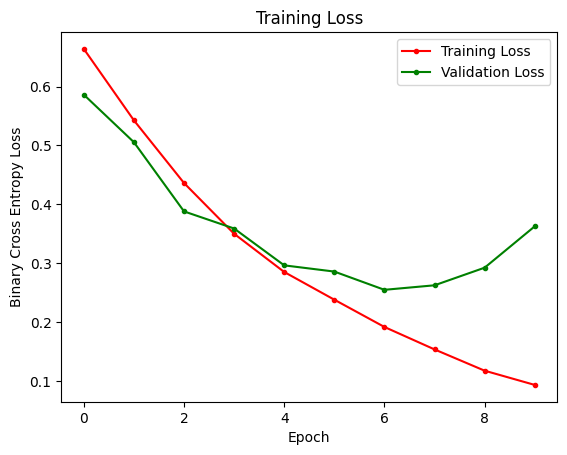

In [200]:
plt.figure()
plt.plot(train_loss, 'r.-')
plt.plot(val_loss, 'g.-')
plt.xlabel("Epoch")
plt.ylabel('Binary Cross Entropy Loss')
plt.title("Training Loss")
plt.legend(['Training Loss', 'Validation Loss'])
plt.show()

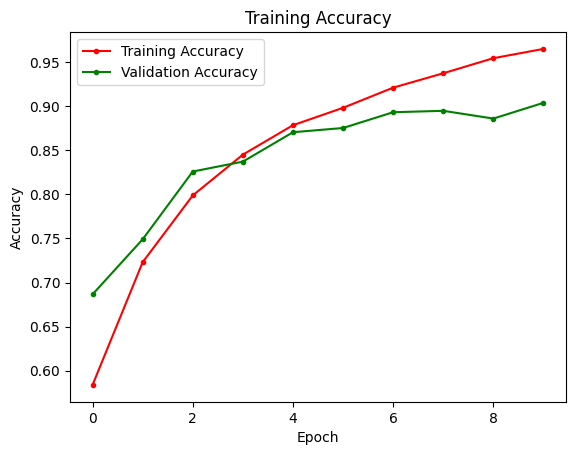

In [199]:
plt.figure()
plt.plot(train_acc, 'r.-')
plt.plot(val_acc, 'g.-')
plt.xlabel("Epoch")
plt.ylabel('Accuracy')
plt.title("Training Accuracy")
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.show()

In [28]:
@torch.no_grad()
def evaluate(model, test_dataloader):
    model.eval()

    ## Forward Pass 
    total_correct_prediction = 0
    for test_images, test_labels in tqdm(test_dataloader):
        test_images = test_images.to(device)
        test_labels = test_labels.to(device)
        results = model(test_images)
        results = results.squeeze()
        results = torch.sigmoid(results).round()
        correct_prediction = (results == test_labels).type(torch.float).sum()
        total_correct_prediction += correct_prediction.item()

    acc = total_correct_prediction / len(test_dataloader)
    return acc

print("Accuracy of model in test datasets: ", evaluate(model, test_dataloader))

NameError: name 'test_dataloader' is not defined

In [23]:
model = AlexNet()

In [24]:
import torch

# Load the saved model
checkpoint = torch.load(r"C:\Users\Lenovo\OneDrive\Desktop\CodePlayGround\CV_with_deep_learning\checkpoints\alexnet_best.pth", map_location=torch.device("cpu"))

# Print the keys in the checkpoint
print(checkpoint.keys())

odict_keys(['feature_extractor.0.weight', 'feature_extractor.0.bias', 'feature_extractor.3.weight', 'feature_extractor.3.bias', 'feature_extractor.6.weight', 'feature_extractor.6.bias', 'feature_extractor.8.weight', 'feature_extractor.8.bias', 'feature_extractor.10.weight', 'feature_extractor.10.bias', 'fcn.0.weight', 'fcn.0.bias', 'fcn.2.weight', 'fcn.2.bias', 'fcn.4.weight', 'fcn.4.bias'])


In [26]:
model.load_state_dict(checkpoint)  # ✅ No need for ["model_state_dict"]
model.eval()

AlexNet(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): Flatten(start_dim=1, end_dim=-1)
  )
  (fcn): Sequential(
    (0): Linear(in_features=9216, out_features=4096, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=4096, 

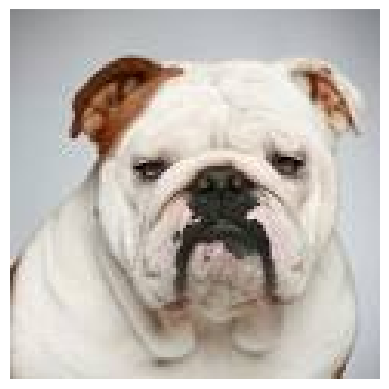

tensor(1.)


In [41]:
import cv2
import torch
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from PIL import Image

# Load image (use PIL instead of OpenCV for compatibility with torchvision)
image_path = r"C:\Users\Lenovo\Downloads\download (1).jpg"
image = Image.open(image_path).convert("RGB")  # Convert to RGB (if not already)

# Display image
plt.imshow(image)
plt.axis("off")  # Hide axes
plt.show()

# # Define transformation (Resize + Convert to Tensor + Normalize)
# transform = transforms.Compose([
#     transforms.Resize((224, 224)),  # Resize to match model input size
#     transforms.ToTensor(),  # Convert image to PyTorch tensor (C, H, W)
#     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize (example)
# ])

# Apply transformation
image = transform(image)

# Add batch dimension (for model input)
image = image.unsqueeze(0)  # Shape: [1, C, H, W]

# Ensure model is in evaluation mode
model.eval()

# Perform inference
with torch.no_grad():  # Disable gradient computation for inference
    result = model(image)
    result = result.squeeze()  # Remove unnecessary dimensions
    result = torch.sigmoid(result).round()  # Apply sigmoid & round to get class

print(result)  # Output: 0 (Cat) or 1 (Dog)


In [ ]:
# class VGG16(nn.Module):
#     def __init__(self):
#         super(VGG16, self). __init__()

#         self.features = nn.Sequential(
#             nn.Conv2d(3, 64, kernel_size = 3, stride = 1, padding = 1),   #<---224 *224 *3
#             nn.ReLU(inplace = True),
#             nn.Conv2d(64, 64, kernel_size = 3, stride = 1, padding = 1),
#             nn.ReLU(inplace = True),
#             nn.MaxPool2d(kernel_size = 2, stride = 2) ,          #----> 112 * 112 * 64

#             nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
#             nn.ReLU(inplace = True),
#             nn.Conv2d(128, 128, kernel_size = 3, stride = 1, padding = 1),
#             nn.ReLU(inplace = True),
#             nn.MaxPool2d(kernel_size = 2, stride = 2) ,     #---> 56 * 56 * 128

#             nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1),
#             nn.ReLU(inplace = True),
#             nn.Conv2d(256, 256, kernel_size = 3, stride = 1, padding = 1),
#             nn.ReLU(inplace = True),
#             nn.Conv2d(256, 256, kernel_size = 3, stride = 1, padding = 1),
#             nn.ReLU(inplace = True),
#             nn.MaxPool2d(kernel_size = 2, stride = 2),      #---> 28 * 28 * 256

#             nn.Conv2d(256, 512, kernel_size = 3, stride = 1, padding = 1),
#             nn.ReLU(inplace = True),
#             nn.Conv2d(512, 512, kernel_size = 3, stride = 1, padding = 1),
#             nn.ReLU(inplace = True),
#             nn.Conv2d(512, 512, kernel_size = 3, stride = 1, padding = 1),
#             nn.ReLU(inplace = True),
#             nn.MaxPool2d(kernel_size = 2, stride = 2),      #---> 14 * 14 * 512


#             nn.Conv2d(512, 512, kernel_size = 3, stride = 1, padding = 1),
#             nn.ReLU(inplace = True),
#             nn.Conv2d(512, 512, kernel_size = 3, stride = 1, padding = 1),
#             nn.ReLU(inplace = True),
#             nn.Conv2d(512, 512, kernel_size = 3, stride = 1, padding = 1),
#             nn.ReLU(inplace = True),
#             nn.MaxPool2d(kernel_size = 2, stride = 2),      #--> 7 * 7 * 512

#             nn.Flatten()
#         )

#         self.fcn = nn.Sequential(
#             nn.Linear(7 * 7 * 512, 4096),
#             nn.ReLU(inplace = True),
#             nn.Linear(4096, 4096),
#             nn.ReLU(inplace = True),
#             nn.Linear(4096, 1)
#         )

#     def forward(self, x):
#         feature_map = self.features(x)
#         output = self.fcn(feature_map)
#         return output.shape

# vgg16 = VGG16()

In [198]:
# for image, _ in train_dataloader:
#     image = image[0].unsqueeze(0)
#     print(vgg16(image))
#     break